In [2]:
import pandas as pd
import numpy as np
import json
import glob
import re

import seaborn as sns

sns.set()

In [3]:
log_path = 'data/hand_eye_combined_logs'

dfs = []

for f in glob.glob(log_path + "/*_Normalized.txt"):
  d = pd.read_csv(f, sep="\s+")
  id = re.findall(".*Subject_(\d+)_.*", f)[0]
  d["id"] = id
  # forward/back fill NaN values to previous/next position 
  d['LeftY'] = d['LeftY'].ffill()
  d['LeftY'] = d['LeftY'].bfill()
  d['RightY'] = d['RightY'].ffill()
  d['RightY'] = d['RightY'].bfill()

  dfs.append(d)

df = pd.concat(dfs, ignore_index=True)

In [4]:
# look at time occurences across students – some students' sessions were longer than others
highest_time_occurence = max(df['TIME[s]'].value_counts())
df_common_time = df.groupby('TIME[s]').filter(lambda x: len(x) == highest_time_occurence)
df_common_time = df_common_time.iloc[1:,:].reset_index()

print(f"from %i to %i rows, a reduction of %.2f percent" % (len(df), len(df_common_time), (len(df) - len(df_common_time))/len(df)*100))
print(df['id'].value_counts())
print(df_common_time['id'].value_counts())

from 41676 to 27425 rows, a reduction of 34.19 percent
12    5639
11    4849
33    3549
07    3409
10    3289
06    3069
02    2639
03    2559
08    2559
04    2109
13    2029
15    2029
01    1989
14    1959
Name: id, dtype: int64
02    1959
03    1959
04    1959
11    1959
06    1959
13    1959
14    1959
01    1959
08    1959
15    1959
12    1959
07    1959
33    1959
10    1958
Name: id, dtype: int64


In [5]:
# calculate the euclidian distance between eye gaze and left/right hand
# Q: how do we engineer a feature that represents the coordination between both hands at once?
from math import sqrt
df['left_gaze_distance'] = ((df['LeftX'] - df['GazeX'])**2 + (df['LeftY'] - df['GazeY'])**2).apply(sqrt)
df['right_gaze_distance'] = ((df['RightX'] - df['GazeX'])**2 + (df['RightY'] - df['GazeY'])**2).apply(sqrt)

In [6]:
# turn the aggregated data frame into a one-student-per-row dataframe
left_df = df.pivot(index='id', columns='TIME[s]', values='left_gaze_distance').reset_index()
right_df = df.pivot(index='id', columns='TIME[s]', values='right_gaze_distance').reset_index()
left_df.columns.name=None
right_df.columns.name=None

# Have only one dataframe with both left and right coordinations as a tuple:
coordination_df = (pd.concat([left_df.loc[:, left_df.columns!='id'],right_df.loc[:, left_df.columns!='id']])
   .stack()
   .groupby(level=[0,1])
   .apply(tuple)
   .unstack()
 )

coordination_df['id'] = left_df['id']

left_df.set_index('id', inplace=True)
right_df.set_index('id', inplace=True)
coordination_df.set_index('id', inplace=True)

# Drop student one who had no data, and drop time 0.0 which had no data
coordination_df = coordination_df.iloc[1:, 1:]
left_df = left_df.iloc[1:, 1:]
right_df = right_df.iloc[1:, 1:]

coordination_df.head()

,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,...,562.9,563.0,563.1,563.2,563.3,563.4,563.5,563.6,563.7,563.8
id,,,,,,,,,,,,,,,,,,,,,
02,"(183.74166647769363, 209.1219739769114)","(38.91015291668744, 397.7863748295057)","(38.01315561749642, 398.72296146572745)","(36.235341863986875, 399.66235749692515)","(30.01666203960727, 398.2122549595881)","(367.98369529097346, 44.77722635447622)","(366.41506519246724, 37.8021163428716)","(363.72792029207767, 27.784887978899608)","(359.0891254271006, 30.528675044947494)","(398.0113063720678, 24.698178070456937)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03,"(249.43536236869062, 258.15692901799093)","(26.870057685088806, 380.9580029347067)","(26.870057685088806, 380.888435109285)","(24.698178070456937, 381.8193290026056)","(20.09975124224178, 381.8193290026056)","(464.32100964742057, 95.524865872714)","(463.67445476325304, 94.79451460923254)","(463.38968482261237, 93.38094023943002)","(463.2763753959401, 93.38094023943002)","(463.1306511126207, 92.69843580125827)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04,"(180.7373785358192,)","(184.43969204051496,)","(186.86893802876924,)","(374.73323845103465, 257.76927667974707)","(373.4059453195677, 258.3815008858026)","(370.1351104664349, 257.1089263327899)","(369.55784391621296, 257.1089263327899)","(368.7411015875502, 256.49366463910957)","(367.589444897429, 256.49366463910957)","(367.0163484097132, 255.55038642115179)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07,"(205.34117950377123,)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# turn the aggregated data frame into a one-student-per-row dataframe
pivoted_df = df.pivot(index='id', columns='TIME[s]', values='left_gaze_distance').reset_index()
right_df = df.pivot(index='id', columns='TIME[s]', values='right_gaze_distance').reset_index()
left_df.columns.name=None
right_df.columns.name=None

In [10]:
df_common_time['Y_proportion'] = df_common_time['RightY'] / df_common_time['LeftY']

In [11]:
# approach: bin time series data based on % time in green for a window of time
# use rnn to predict next % in green given sequence of previous % in green

window = 10 # window of 10 ==> 1 second
rows = []

for group_id, group_df in df_common_time.groupby(['id']):
    start = 0

    for i in range(int(len(group_df) / window)):
      slice = group_df.iloc[start:start+window]
      avg_proportion = slice['Y_proportion'].mean()

      t_start = group_df.iloc[start]['TIME[s]']
      t_end = group_df.iloc[start+window]['TIME[s]']
      if(group_id == '10'):
          t_start = np.ceil(t_start - .1)
          t_end = np.ceil(t_end - .1)

      time_range = f"%s_%s" % (t_start, t_end)

      row = [
          group_id, 
          time_range,
          avg_proportion
          ]

      rows.append(row)
      start = start + window

pro_df = pd.DataFrame(rows,
    columns=[
        'id', 
        'time_window', 
        "avg_proportion"
        ])


In [12]:
pro_df['pro_diff'] = np.abs(2 - pro_df['avg_proportion'])

In [13]:
def assign_bin(pro_diff):
  if(pro_diff) < .01: return 0
  if(pro_diff) < .03: return 1
  if(pro_diff) < .05: return 2
  if(pro_diff) < .7: return 3
  elif(pro_diff) < 1: return 4
  elif(pro_diff) < 2: return 5
  elif(pro_diff) < 3: return 6
  else: return 7

In [19]:
pro_df['pro_bin'] = pro_df['pro_diff'].apply(assign_bin)
num_bins = len(pro_df['pro_bin'].unique())
pro_df['pro_bin'].value_counts()


3    809
5    758
4    432
1    307
0    185
2    179
7     43
6     17
Name: pro_bin, dtype: int64

<AxesSubplot:xlabel='pro_bin', ylabel='Count'>

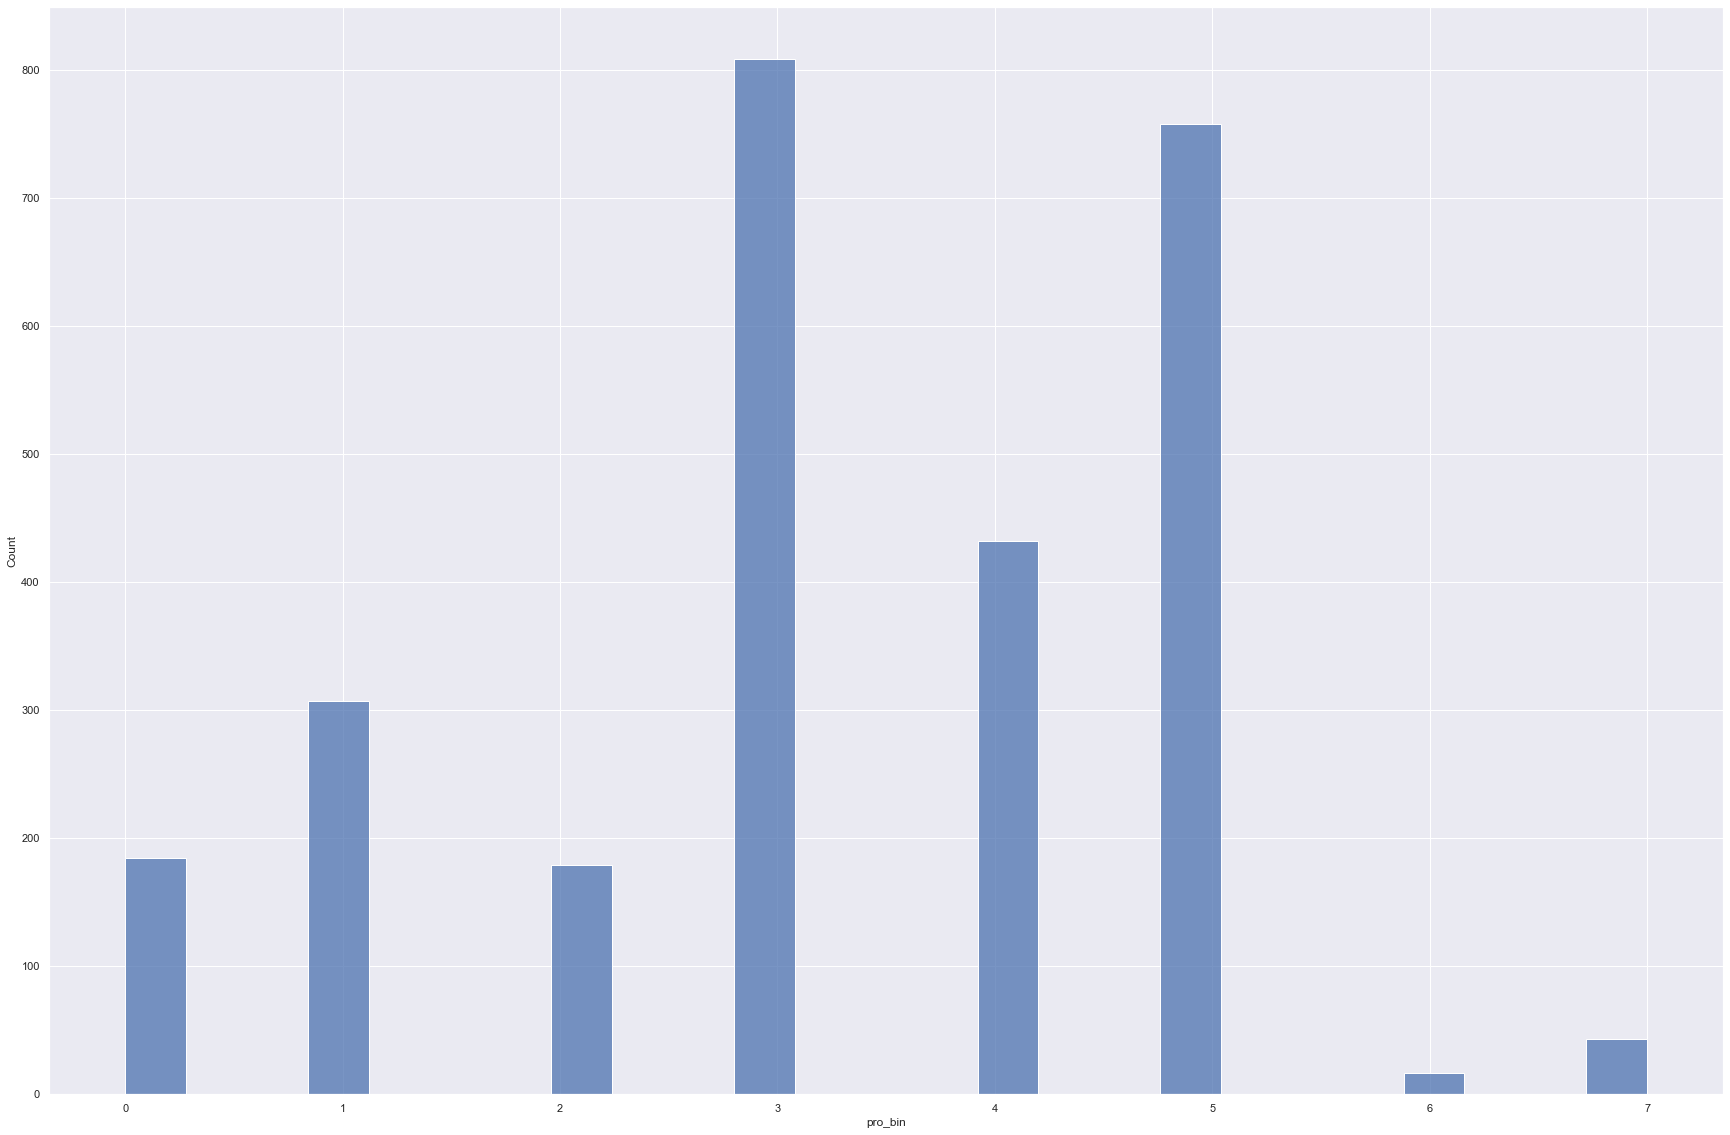

In [19]:
sns.set(rc={"figure.figsize":(30, 20)})

sns.histplot(data=pro_df, x="pro_bin")

In [15]:
# turn the aggregated data frame into a one-student-per-row dataframe
pro_df_pivot = pro_df.pivot(index='id', columns='time_window', values='pro_bin').reset_index()
pro_df_pivot.columns.name=None

pro_df_pivot

,id,0.0_1.0,1.0_2.0,10.0_11.0,100.0_101.0,101.0_102.0,102.0_103.0,103.0_104.0,104.0_105.0,105.0_106.0,...,90.0_91.0,91.0_92.0,92.0_93.0,93.0_94.0,94.0_95.0,95.0_96.0,96.0_97.0,97.0_98.0,98.0_99.0,99.0_100.0
0,01,5,5,4,3,3,5,4,4,5,...,1,1,1,3,3,3,3,5,5,4
1,02,4,4,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
2,03,5,5,5,5,5,5,5,5,5,...,3,5,5,4,4,4,4,4,4,4
3,04,5,5,5,4,5,3,3,3,5,...,4,4,5,4,4,4,5,5,4,4
4,06,3,5,3,3,1,0,0,2,3,...,3,3,3,3,5,3,4,4,3,3
5,07,5,5,5,5,4,4,3,3,2,...,4,5,5,5,5,5,5,5,5,5
6,08,5,4,3,3,3,3,3,3,3,...,2,0,0,1,1,1,1,3,4,5
7,10,4,4,0,1,1,0,3,3,4,...,3,0,1,3,1,1,1,1,1,1
8,11,4,4,5,5,5,5,5,4,3,...,7,7,7,7,7,5,5,5,4,4
9,12,5,5,4,3,3,3,0,1,1,...,0,3,3,3,3,3,3,3,3,3


In [16]:
from keras.layers import Input, Dense, LSTM, TimeDistributed, Lambda, multiply
from keras.models import Model
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K

def build_s2s_model(input_shape, lstm_dim=32, dropout=0.0):
    input = Input(shape=input_shape, name='input coordinations')
    lstm = LSTM(lstm_dim, 
                return_sequences=True, 
                dropout=dropout,
                name='lstm_layer')(input)
    output = TimeDistributed(Dense(input_shape[-1], activation='softmax'), name='probability')(lstm)
    model = Model(inputs=[input], outputs=[output])
    adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[RootMeanSquaredError()])
    model.summary()
    return model

In [27]:
s2s_model = build_s2s_model((194, num_bins), lstm_dim=64)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input coordinations (InputL  [(None, 194, 8)]         0         
 ayer)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 194, 64)           18688     
                                                                 
 probability (TimeDistribute  (None, 194, 8)           520       
 d)                                                              
                                                                 
Total params: 19,208
Trainable params: 19,208
Non-trainable params: 0
_________________________________________________________________


In [22]:
def preprocess(df, num_bins):
  matrix = df.iloc[:, 1:].values
  num_bins = num_bins

  seq_len = matrix.shape[1]
  one_hot_array = np.zeros((matrix.shape[0], seq_len, num_bins))
  for i in range(matrix.shape[0]):
      one_hot_array[i, np.arange(seq_len), matrix[i]] = 1
  return one_hot_array

In [23]:
# 70% of data used as training data
test_prop = 0.7

# Split user_ids/student_ids into 70% training and 30% test data
idx_split = np.array(pro_df_pivot['id'].unique())
np.random.seed(42)
np.random.shuffle(idx_split)
train_ids = idx_split[:int(test_prop * len(idx_split))]
test_ids = idx_split[int(test_prop * len(idx_split)):]

# Split skill_df
train_df = pro_df_pivot.loc[pro_df_pivot['id'].isin(train_ids)].reset_index(drop = True)
test_df = pro_df_pivot.loc[pro_df_pivot['id'].isin(test_ids)].reset_index(drop = True)

# Checking that the ratio of training data to test data is adequate
print('Training data is %5.3f' % (train_df.shape[0]/pro_df_pivot.shape[0]),'% of total data')
print('Testing data is %5.3f' % (test_df.shape[0]/pro_df_pivot.shape[0]),'% of total data')

train_array = preprocess(train_df, num_bins)
test_array = preprocess(test_df, num_bins)


Training data is 0.643 % of total data
Testing data is 0.357 % of total data


In [28]:
s2s_model.fit(train_array[:, 0:-1], 
                      train_array[:, 1:],
                      epochs=20, 
                      batch_size=8, 
                      shuffle=True,
                      validation_split=0.3)
                      

Epoch 1/20


2022-05-06 16:45:09.508602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-06 16:45:09.661916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-06 16:45:10.108049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2.0683 - root_mean_squared_error: 0.3302

2022-05-06 16:45:11.086922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-06 16:45:11.137981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step - loss: 2.0683 - root_mean_squared_error: 0.3302 - val_loss: 2.0616 - val_root_mean_squared_error: 0.3299
Epoch 2/20
1/1 [==============================] - 0s 113ms/step - loss: 2.0520 - root_mean_squared_error: 0.3295 - val_loss: 2.0526 - val_root_mean_squared_error: 0.3295
Epoch 3/20
1/1 [==============================] - 0s 117ms/step - loss: 2.0358 - root_mean_squared_error: 0.3287 - val_loss: 2.0435 - val_root_mean_squared_error: 0.3290
Epoch 4/20
1/1 [==============================] - 0s 132ms/step - loss: 2.0194 - root_mean_squared_error: 0.3279 - val_loss: 2.0343 - val_root_mean_squared_error: 0.3286
Epoch 5/20
1/1 [==============================] - 0s 114ms/step - loss: 2.0026 - root_mean_squared_error: 0.3271 - val_loss: 2.0249 - val_root_mean_squared_error: 0.3281
Epoch 6/20
1/1 [==============================] - 0s 85ms/step - loss: 1.9853 - root_mean_squared_error: 0.3262 - val_loss: 2.0151 - val_root_mean_squared_error: 0.

In [44]:
# Make a prediction on testing data
test_predict = s2s_model.predict(test_array[:, 0:-1])
print("Shape of prediction on test set:", test_predict.shape, ' = (student, time step, proportion) \n')

# Evaulate model prediction accuracy on test data
results = s2s_model.evaluate(test_array[:, 0:-1], test_array[:, 1:])
print('\nThe overall accuracy of skill prediction in the test set is: %5.2f' % (results[1]))

Shape of prediction on test set: (5, 194, 8)  = (student, time step, proportion) 

1/1 [==============================] - 0s 93ms/step - loss: 1.7374 - root_mean_squared_error: 0.3148

The overall accuracy of skill prediction in the test set is:  0.31


In [63]:
from sklearn.metrics import mean_squared_error

y_pred_avg = [i / len(pro_df['pro_bin']) for i in pro_df['pro_bin'].value_counts()]

f2 = lambda p: mean_squared_error(y_pred_avg, p, squared=False)
f1 = lambda r: f2(r)

avg_rmse = []
for r in test_array:
  for p in r:
    avg_rmse.append(mean_squared_error(y_pred_avg, p, squared=False))

np.mean(avg_rmse)

0.34713590663006444

In [35]:
models = []

for lstm_dim in [64, 128]:
    for batch_size in [8, 16]:
        for validation_split in [0, 0.1, 0.2, 0.3]:
            s2s_model = build_s2s_model((194, num_bins), lstm_dim=lstm_dim)
            
            s2s_model.fit(train_array[:, 0:-1], 
                      train_array[:, 1:],
                      epochs=20, 
                      batch_size=batch_size, 
                      shuffle=True,
                      validation_split=validation_split, verbose=0)

            # Evaulate model prediction accuracy on test data
            results = s2s_model.evaluate(test_array[:, 0:-1], test_array[:, 1:])

            models.append({'lstm_dim': lstm_dim, 'batch_size': batch_size, 'validation_split': validation_split, 'rmse': results[1]}) 

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input coordinations (InputL  [(None, 194, 8)]         0         
 ayer)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 194, 64)           18688     
                                                                 
 probability (TimeDistribute  (None, 194, 8)           520       
 d)                                                              
                                                                 
Total params: 19,208
Trainable params: 19,208
Non-trainable params: 0
_________________________________________________________________


2022-05-02 15:43:19.878005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:20.075277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:20.739878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:24.176808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:24.241146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 495ms/step - loss: 1.6342 - root_mean_squared_error: 0.3076
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input coordinations (InputL  [(None, 194, 8)]         0         
 ayer)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 194, 64)           18688     
                                                                 
 probability (TimeDistribute  (None, 194, 8)           520       
 d)                                                              
                                                                 
Total params: 19,208
Trainable params: 19,208
Non-trainable params: 0
_________________________________________________________________


2022-05-02 15:43:25.323370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:25.441473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:25.717642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:26.664456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:26.725225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 260ms/step - loss: 1.6864 - root_mean_squared_error: 0.3112
Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input coordinations (InputL  [(None, 194, 8)]         0         
 ayer)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 194, 64)           18688     
                                                                 
 probability (TimeDistribute  (None, 194, 8)           520       
 d)                                                              
                                                                 
Total params: 19,208
Trainable params: 19,208
Non-trainable params: 0
_________________________________________________________________


2022-05-02 15:43:30.467572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:30.615062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:30.938009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:31.660997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:31.737307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 228ms/step - loss: 1.7248 - root_mean_squared_error: 0.3152
Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input coordinations (InputL  [(None, 194, 8)]         0         
 ayer)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 194, 64)           18688     
                                                                 
 probability (TimeDistribute  (None, 194, 8)           520       
 d)                                                              
                                                                 
Total params: 19,208
Trainable params: 19,208
Non-trainable params: 0
_________________________________________________________________


2022-05-02 15:43:34.588524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:34.719577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:35.040609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:36.217103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:36.315502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 230ms/step - loss: 1.8079 - root_mean_squared_error: 0.3224
Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input coordinations (InputL  [(None, 194, 8)]         0         
 ayer)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 194, 64)           18688     
                                                                 
 probability (TimeDistribute  (None, 194, 8)           520       
 d)                                                              
                                                                 
Total params: 19,208
Trainable params: 19,208
Non-trainable params: 0
_________________________________________________________________


2022-05-02 15:43:39.154860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:39.301187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:39.630311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:41.276891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:41.329293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 473ms/step - loss: 1.6631 - root_mean_squared_error: 0.3082
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input coordinations (InputL  [(None, 194, 8)]         0         
 ayer)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 194, 64)           18688     
                                                                 
 probability (TimeDistribute  (None, 194, 8)           520       
 d)                                                              
                                                                 
Total params: 19,208
Trainable params: 19,208
Non-trainable params: 0
_________________________________________________________________


2022-05-02 15:43:42.831320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:42.970858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:43.276698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:43.953101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:44.005132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 233ms/step - loss: 1.6772 - root_mean_squared_error: 0.3083
Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input coordinations (InputL  [(None, 194, 8)]         0         
 ayer)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 194, 64)           18688     
                                                                 
 probability (TimeDistribute  (None, 194, 8)           520       
 d)                                                              
                                                                 
Total params: 19,208
Trainable params: 19,208
Non-trainable params: 0
_________________________________________________________________


2022-05-02 15:43:46.868878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:46.993209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:47.287363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:47.946677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:47.997507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 223ms/step - loss: 1.7009 - root_mean_squared_error: 0.3128
Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input coordinations (InputL  [(None, 194, 8)]         0         
 ayer)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 194, 64)           18688     
                                                                 
 probability (TimeDistribute  (None, 194, 8)           520       
 d)                                                              
                                                                 
Total params: 19,208
Trainable params: 19,208
Non-trainable params: 0
_________________________________________________________________


2022-05-02 15:43:51.033155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:51.157475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:51.482084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:52.227279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:52.280087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 274ms/step - loss: 1.7473 - root_mean_squared_error: 0.3153
Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input coordinations (InputL  [(None, 194, 8)]         0         
 ayer)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 194, 128)          70144     
                                                                 
 probability (TimeDistribute  (None, 194, 8)           1032      
 d)                                                              
                                                                 
Total params: 71,176
Trainable params: 71,176
Non-trainable params: 0
_________________________________________________________________


2022-05-02 15:43:55.602680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:55.757328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:56.112458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:59.085787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:43:59.141740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 452ms/step - loss: 1.6206 - root_mean_squared_error: 0.3060
Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input coordinations (InputL  [(None, 194, 8)]         0         
 ayer)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 194, 128)          70144     
                                                                 
 probability (TimeDistribute  (None, 194, 8)           1032      
 d)                                                              
                                                                 
Total params: 71,176
Trainable params: 71,176
Non-trainable params: 0
_________________________________________________________________


2022-05-02 15:44:00.124624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:00.237043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:00.605491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:01.357825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:01.410585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 239ms/step - loss: 1.6100 - root_mean_squared_error: 0.3046
Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input coordinations (InputL  [(None, 194, 8)]         0         
 ayer)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 194, 128)          70144     
                                                                 
 probability (TimeDistribute  (None, 194, 8)           1032      
 d)                                                              
                                                                 
Total params: 71,176
Trainable params: 71,176
Non-trainable params: 0
_________________________________________________________________


2022-05-02 15:44:04.672005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:04.837998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:05.189896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:05.914471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:05.967335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 277ms/step - loss: 1.6668 - root_mean_squared_error: 0.3105
Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input coordinations (InputL  [(None, 194, 8)]         0         
 ayer)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 194, 128)          70144     
                                                                 
 probability (TimeDistribute  (None, 194, 8)           1032      
 d)                                                              
                                                                 
Total params: 71,176
Trainable params: 71,176
Non-trainable params: 0
_________________________________________________________________


2022-05-02 15:44:09.435633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:09.597451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:09.943147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:10.678606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:10.735161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 247ms/step - loss: 1.6362 - root_mean_squared_error: 0.3063
Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input coordinations (InputL  [(None, 194, 8)]         0         
 ayer)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 194, 128)          70144     
                                                                 
 probability (TimeDistribute  (None, 194, 8)           1032      
 d)                                                              
                                                                 
Total params: 71,176
Trainable params: 71,176
Non-trainable params: 0
_________________________________________________________________


2022-05-02 15:44:13.813677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:13.968185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:14.294471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:15.834250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:15.894375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 534ms/step - loss: 1.6151 - root_mean_squared_error: 0.3047
Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input coordinations (InputL  [(None, 194, 8)]         0         
 ayer)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 194, 128)          70144     
                                                                 
 probability (TimeDistribute  (None, 194, 8)           1032      
 d)                                                              
                                                                 
Total params: 71,176
Trainable params: 71,176
Non-trainable params: 0
_________________________________________________________________


2022-05-02 15:44:17.451377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:17.598257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:17.945623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:18.660748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:18.718688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 250ms/step - loss: 1.6076 - root_mean_squared_error: 0.3045
Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input coordinations (InputL  [(None, 194, 8)]         0         
 ayer)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 194, 128)          70144     
                                                                 
 probability (TimeDistribute  (None, 194, 8)           1032      
 d)                                                              
                                                                 
Total params: 71,176
Trainable params: 71,176
Non-trainable params: 0
_________________________________________________________________


2022-05-02 15:44:22.287821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:22.446953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:22.755406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:23.429851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:23.480918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 281ms/step - loss: 1.6078 - root_mean_squared_error: 0.3042
Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input coordinations (InputL  [(None, 194, 8)]         0         
 ayer)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 194, 128)          70144     
                                                                 
 probability (TimeDistribute  (None, 194, 8)           1032      
 d)                                                              
                                                                 
Total params: 71,176
Trainable params: 71,176
Non-trainable params: 0
_________________________________________________________________


2022-05-02 15:44:26.837247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:26.998605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:27.389360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:28.129393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-02 15:44:28.184273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 237ms/step - loss: 1.6437 - root_mean_squared_error: 0.3070


In [36]:
sorted(models, key=lambda d: d['rmse']) 

[{'lstm_dim': 128,
  'batch_size': 16,
  'validation_split': 0.2,
  'rmse': 0.30424177646636963},
 {'lstm_dim': 128,
  'batch_size': 16,
  'validation_split': 0.1,
  'rmse': 0.3045192062854767},
 {'lstm_dim': 128,
  'batch_size': 8,
  'validation_split': 0.1,
  'rmse': 0.3046152591705322},
 {'lstm_dim': 128,
  'batch_size': 16,
  'validation_split': 0,
  'rmse': 0.3047221601009369},
 {'lstm_dim': 128,
  'batch_size': 8,
  'validation_split': 0,
  'rmse': 0.3059903681278229},
 {'lstm_dim': 128,
  'batch_size': 8,
  'validation_split': 0.3,
  'rmse': 0.3063153326511383},
 {'lstm_dim': 128,
  'batch_size': 16,
  'validation_split': 0.3,
  'rmse': 0.3070237338542938},
 {'lstm_dim': 64,
  'batch_size': 8,
  'validation_split': 0,
  'rmse': 0.3075912892818451},
 {'lstm_dim': 64,
  'batch_size': 16,
  'validation_split': 0,
  'rmse': 0.3082329034805298},
 {'lstm_dim': 64,
  'batch_size': 16,
  'validation_split': 0.1,
  'rmse': 0.3083004653453827},
 {'lstm_dim': 128,
  'batch_size': 8,
  'val